# Building Stacked Ensembles

## Import Packages 

In [0]:
from IPython.display import display, HTML, Image


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
from random import randint
import math

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
from scipy.spatial import distance
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import export_graphviz
from sklearn import tree
from sklearn import metrics
from sklearn import tree
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn import linear_model
from sklearn import neighbors
from sklearn.utils import resample
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import KFold
import itertools
%matplotlib inline
#%qtconsole

## Define StackedEnsembleClassifier

Utility function to create classifer objects based on a name

In [0]:
def create_classifier(classifier_type, tree_min_samples_split = 20):

    if classifier_type == "svm":
        c = svm.SVC(probability=True,gamma='auto')

    elif classifier_type == "logreg":
        c = linear_model.LogisticRegression(multi_class='ovr', solver='liblinear', max_iter=1000)

    elif classifier_type == "knn":
        c = neighbors.KNeighborsClassifier()

    elif classifier_type == "tree":
        c = tree.DecisionTreeClassifier(min_samples_split = tree_min_samples_split)

    elif classifier_type == "randomforest":
        c = ensemble.RandomForestClassifier()
        
    else:
        c = linear_model.LogisticRegression(multi_class='ovr', solver='liblinear', max_iter=1000)
    
    return c

StackedEnsembleClassifier class.

In [0]:
# Create a new classifier which is based on the sckit-learn BaseEstimator and ClassifierMixin classes
class StackedEnsembleClassifier(BaseEstimator, ClassifierMixin):
    
    """An ensemble classifier that uses heterogeneous models at the base layer and a aggregatnio model at the aggregation layer. A k-fold cross validation is used to gnerate training data for the stack layer model.

    Parameters
    ----------
    base_estimators: list 
        A list of the classifiers in the base layer of the ensemble. Supported types are
        - "svm" Support Vector Machine implemented by sklearn.svm.SVC
        - "logreg" Logistic Regression implemented by sklearn.linear_models.LogisticRegression
        - "knn" k Nearest Neighbour implemented by sklearn.neighbors.KNeighborsClassifier
        - "tree" Decision Tree implemented by sklearn.tree.DecisionTreeClassifier
        - "randomforest" RandomForest implemented by sklearn.tree.RandomForestClassifier    
    classifier_duplicates: int, optional (default = 1)
        How many instances of each classifier type listed in base_estimators is included in the ensemble
    stack_layer_classifier: string, optional (default = "logreg')
        The classifier type used at the stack layer. The same classifier types as are supported at the base layer are supported        
    training_folds: int, optional (default = 4)
        How many folds will be used to generate the training set for the stacked layer
        
    Attributes
    ----------
    classes_ : array of shape = [n_classes] 
        The classes labels (single output problem).


    Notes
    -----
    The default values for most base learners are used.

    See also
    --------
    
    ----------
    .. [1]  van der Laan, M., Polley, E. & Hubbard, A. (2007). 
            Super Learner. Statistical Applications in Genetics 
            and Molecular Biology, 6(1) 
            doi:10.2202/1544-6115.1309
    Examples
    --------
    >>> from sklearn.datasets import load_iris
    >>> from sklearn.model_selection import cross_val_score
    >>> clf = StackedEnsembleClassifier()
    >>> iris = load_iris()
    >>> cross_val_score(clf, iris.data, iris.target, cv=10)

    """
    # Constructor for the classifier object
    def __init__(self, base_estimator_types = ["svm", "logreg", "tree"], base_estimator_duplicates = 8, stack_layer_classifier_type = "logreg"):
        """Setup a SuperLearner classifier .
        Parameters
        ----------
        base_estimator_types: The types of classifiers to include at the base layer
        base_estimator_duplicates: The number of duplicates of each type of classiifer to include
        stack_layer_classifier_type: The type of classifier to include at the stack layer 
        
        Returns
        -------
        Nothing
        """     

        # Initialise class variabels
        self.base_estimator_types = base_estimator_types
        self.base_estimator_type_list = list()
        self.base_estimator_duplicates = base_estimator_duplicates
        self.stack_layer_classifier_type = stack_layer_classifier_type
        

    # The fit function to train a classifier
    def fit(self, X, y):
        """Build a SuperLearner classifier from the training set (X, y).
        Parameters
        ----------
        X : array-like, shape = [n_samples, n_features]
            The training input samples. 
        y : array-like, shape = [n_samples] 
            The target values (class labels) as integers or strings.
        Returns
        -------
        self : object
        """    
        
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        # Store the classes seen during fit
        self.classes_ = unique_labels(y)
        
        ########################
        # LEVEL 0
        ########################
        
        # Set up the base classifeirs in the ensemble
        self.classifiers_ = list()
        
        for i in range(0, self.base_estimator_duplicates):
            for t in self.base_estimator_types:

                self.base_estimator_type_list.append(t)      
                c = create_classifier(t, tree_min_samples_split=math.ceil(len(X)*0.05))
                self.classifiers_.append(c)
        
        # Store the number of classifers in the ensemble
        self.n_estimators_ = len(self.classifiers_)

        # Use all training data to train base classifiers
        X_train = X
        y_train = y
        
        # Set up empty arrays to hold stack layer training data
        self.X_stack_train = None #(dtype = float)
        self.y_stack_train = y_train
          
        # Train each base calssifier and generate the stack layer training dataset
        for classifier in self.classifiers_:

            # Extract a bootstrap sample
            X_train_samp, y_train_samp = resample(X_train, y_train, replace=True)    
            
            # Train a base classifier
            classifier.fit(X_train_samp, y_train_samp)
            
            # Make predictions for all instances in the training set
            y_pred = classifier.predict_proba(X_train)

            # Append the predictions ot the stack layer traing set (a bit of hacking here!)
            try:
                self.X_stack_train = np.c_[self.X_stack_train, y_pred]
            except ValueError:
                self.X_stack_train = y_pred
      
        ########################
        # LEVEL 1
        ########################
        
        # Create the stack layer classifier
        self.stack_layer_classifier_ = create_classifier(self.stack_layer_classifier_type, tree_min_samples_split=math.ceil(len(X)*0.05))

        # Train the stack layer using the newly created dataset
        self.stack_layer_classifier_.fit(self.X_stack_train, self.y_stack_train)
            
        # Return the classifier
        return self

    # The predict function to make a set of predictions for a set of query instances
    def predict(self, X):
        """Predict class labels of the input samples X.
        Parameters
        ----------
        X : array-like matrix of shape = [n_samples, n_features]
            The input samples. 
        Returns
        -------
        p : array of shape = [n_samples, ].
            The predicted class labels of the input samples. 
        """
        
        # Check is fit had been called by confirming that the teamplates_ dictiponary has been set up
        check_is_fitted(self, ['stack_layer_classifier_'])

        # Check that the input features match the type and shape of the training features
        X = check_array(X)
   
        X_stack_queries = None
              
        # Make a prediction with each base classifier and assemble the stack layer query
        for classifier in self.classifiers_:
            
            y_pred = classifier.predict_proba(X)
            
            try:
                X_stack_queries = np.c_[X_stack_queries, y_pred]
            except ValueError:
                X_stack_queries = y_pred
        
        # Return the prediction made by the stack layer classifier
        return self.stack_layer_classifier_.predict(X_stack_queries)
    
    # The predict function to make a set of predictions for a set of query instances
    def predict_proba(self, X):
        """Predict class probabilities of the input samples X.
        Parameters
        ----------
        X : array-like matrix of shape = [n_samples, n_features]
            The input samples. 
        Returns
        -------
        p : array of shape = [n_samples, n_labels].
            The predicted class label probabilities of the input samples. 
        """
        # Check is fit had been called by confirming that the teamplates_ dictiponary has been set up
        check_is_fitted(self, ['stack_layer_classifier_'])

        # Check that the input features match the type and shape of the training features
        X = check_array(X)
        
        X_stack_queries = None
        
        # Make a prediction with each base classifier
        for classifier in self.classifiers_:
            
            y_pred = classifier.predict_proba(X)
                
            try:
                X_stack_queries = np.c_[X_stack_queries, y_pred]
            except ValueError:
                X_stack_queries = y_pred

        # Return the prediction made by the stack layer classifier        
        return self.stack_layer_classifier_.predict_proba(X_stack_queries)

## Test the StackedEnsembleClassifier

Perform a simple test using the StackedEnsembleClassifier on the Iris dataset

In [5]:
from sklearn.datasets import load_iris
iris = load_iris()
clf = StackedEnsembleClassifier()
clf.fit(iris.data, iris.target)
y_pred = clf.predict(iris.data)
print(metrics.classification_report(iris.target, y_pred))
print("Confusion Matrix")
display(pd.crosstab(np.array(iris.target), y_pred, rownames=['True'], colnames=['Predicted'], margins=True))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      0.96      0.98        50
           2       0.96      1.00      0.98        50

   micro avg       0.99      0.99      0.99       150
   macro avg       0.99      0.99      0.99       150
weighted avg       0.99      0.99      0.99       150

Confusion Matrix


Predicted,0,1,2,All
True,,,,
0,50,0,0,50
1,0,48,2,50
2,0,0,50,50
All,50,48,52,150


Perform a cross validation experiment

In [6]:
scores = cross_val_score(clf, iris.data, iris.target, cv=10)
print(scores)
print(np.mean(scores), " +/- ", np.std(scores))

[1.         0.93333333 1.         0.93333333 0.93333333 0.93333333
 0.93333333 1.         1.         1.        ]
0.9666666666666666  +/-  0.033333333333333326


## Task 1: Design the StackedEnsembleHoldOut Class

In [0]:
class StackedEnsembleHoldOut(BaseEstimator, ClassifierMixin):
    
    """An ensemble classifier that uses heterogeneous models at the base layer and a aggregatnio model at the aggregation layer. A k-fold cross validation is used to gnerate training data for the stack layer model.

    Parameters
    ----------
    base_estimators: list 
        A list of the classifiers in the base layer of the ensemble. Supported types are
        - "svm" Support Vector Machine implemented by sklearn.svm.SVC
        - "logreg" Logistic Regression implemented by sklearn.linear_models.LogisticRegression
        - "knn" k Nearest Neighbour implemented by sklearn.neighbors.KNeighborsClassifier
        - "tree" Decision Tree implemented by sklearn.tree.DecisionTreeClassifier
        - "randomforest" RandomForest implemented by sklearn.tree.RandomForestClassifier    
    classifier_duplicates: int, optional (default = 1)
        How many instances of each classifier type listed in base_estimators is included in the ensemble
    stack_layer_classifier: string, optional (default = "logreg')
        The classifier type used at the stack layer. The same classifier types as are supported at the base layer are supported        
    training_folds: int, optional (default = 4)
        How many folds will be used to generate the training set for the stacked layer
        
    Attributes
    ----------
    classes_ : array of shape = [n_classes] 
        The classes labels (single output problem).


    Notes
    -----
    The default values for most base learners are used.

    See also
    --------
    
    ----------
    .. [1]  van der Laan, M., Polley, E. & Hubbard, A. (2007). 
            Super Learner. Statistical Applications in Genetics 
            and Molecular Biology, 6(1) 
            doi:10.2202/1544-6115.1309
    Examples
    --------
    >>> from sklearn.datasets import load_iris
    >>> from sklearn.model_selection import cross_val_score
    >>> clf = StackedEnsembleClassifier()
    >>> iris = load_iris()
    >>> cross_val_score(clf, iris.data, iris.target, cv=10)

    """
    # Constructor for the classifier object
    def __init__(self, base_estimator_types = ["svm", "logreg", "tree"], base_estimator_duplicates = 8, stack_layer_classifier_type = "logreg",hold_out_testset=0.3):
        """Setup a SuperLearner classifier .
        Parameters
        ----------
        base_estimator_types: The types of classifiers to include at the base layer
        base_estimator_duplicates: The number of duplicates of each type of classiifer to include
        stack_layer_classifier_type: The type of classifier to include at the stack layer 
        hold_out_testset: Percentage of the data to be hold out to test and generate stack layed training data
        Returns
        -------
        Nothing
        """     

        # Initialise class variabels
        self.base_estimator_types = base_estimator_types
        self.base_estimator_type_list = list()
        self.base_estimator_duplicates = base_estimator_duplicates
        self.stack_layer_classifier_type = stack_layer_classifier_type
        self.hold_out_testset = hold_out_testset

    # The fit function to train a classifier
    def fit(self, X, y):
        """Build a SuperLearner classifier from the training set (X, y).
        Parameters
        ----------
        X : array-like, shape = [n_samples, n_features]
            The training input samples. 
        y : array-like, shape = [n_samples] 
            The target values (class labels) as integers or strings.
        Returns
        -------
        self : object
        """    
        
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        # Store the classes seen during fit
        self.classes_ = unique_labels(y)
        
        ########################
        # LEVEL 0
        ########################
        
        # Set up the base classifeirs in the ensemble
        self.classifiers_ = list()
        
        for i in range(0, self.base_estimator_duplicates):
            for t in self.base_estimator_types:

                self.base_estimator_type_list.append(t)      
                c = create_classifier(t, tree_min_samples_split=math.ceil(len(X)*0.05))
                self.classifiers_.append(c)
        
        # Store the number of classifers in the ensemble
        self.n_estimators_ = len(self.classifiers_)

        # Split data into training and holdout set       
        
        X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=self.hold_out_testset)
        
        # Set up empty arrays to hold stack layer training data
        self.X_stack_train = None #(dtype = float)
        self.y_stack_train = y_holdout
          
        # Train each base calssifier and generate the stack layer training dataset
        for classifier in self.classifiers_:

            # Train a base classifier 
            classifier.fit(X_train, y_train)
            
            # Make predictions for all instances in the holdout set
            y_pred = classifier.predict_proba(X_holdout)

            # Append the predictions to the stack layer traing set (a bit of hacking here!)
            try:
                self.X_stack_train = np.c_[self.X_stack_train, y_pred]
            except ValueError:
                self.X_stack_train = y_pred
      
        ########################
        # LEVEL 1
        ########################
                
        
        # Create the stack layer classifier
        self.stack_layer_classifier_ = create_classifier(self.stack_layer_classifier_type, tree_min_samples_split=math.ceil(len(X)*0.05))

        # Train the stack layer using the newly created dataset
        self.stack_layer_classifier_.fit(self.X_stack_train, self.y_stack_train)
        
        # Train the base classifier on all the data 
        
        for classifier in self.classifiers_:            
            # Train a base classifier
            classifier.fit(X, y)

        return self

    # The predict function to make a set of predictions for a set of query instances
    def predict(self, X):
        """Predict class labels of the input samples X.
        Parameters
        ----------
        X : array-like matrix of shape = [n_samples, n_features]
            The input samples. 
        Returns
        -------
        p : array of shape = [n_samples, ].
            The predicted class labels of the input samples. 
        """
        
        # Check is fit had been called by confirming that the teamplates_ dictiponary has been set up
        check_is_fitted(self, ['stack_layer_classifier_'])

        # Check that the input features match the type and shape of the training features
        X = check_array(X)
   
        X_stack_queries = None
              
        # Make a prediction with each base classifier and assemble the stack layer query
        for classifier in self.classifiers_:
            
            y_pred = classifier.predict_proba(X)
            
            try:
                X_stack_queries = np.c_[X_stack_queries, y_pred]
            except ValueError:
                X_stack_queries = y_pred
        
        # Return the prediction made by the stack layer classifier
        return self.stack_layer_classifier_.predict(X_stack_queries)
    
    # The predict function to make a set of predictions for a set of query instances
    def predict_proba(self, X):
        """Predict class probabilities of the input samples X.
        Parameters
        ----------
        X : array-like matrix of shape = [n_samples, n_features]
            The input samples. 
        Returns
        -------
        p : array of shape = [n_samples, n_labels].
            The predicted class label probabilities of the input samples. 
        """
        # Check is fit had been called by confirming that the teamplates_ dictiponary has been set up
        check_is_fitted(self, ['stack_layer_classifier_'])

        # Check that the input features match the type and shape of the training features
        X = check_array(X)
        
        X_stack_queries = None
        
        # Make a prediction with each base classifier
        for classifier in self.classifiers_:
            
            y_pred = classifier.predict_proba(X)
                
            try:
                X_stack_queries = np.c_[X_stack_queries, y_pred]
            except ValueError:
                X_stack_queries = y_pred

        # Return the prediction made by the stack layer classifier        
        return self.stack_layer_classifier_.predict_proba(X_stack_queries)

## Test the StackedEnsembleHoldout

Perform a simple test using the StackedEnsembleHoldout on the Iris dataset

In [8]:
from sklearn.datasets import load_iris
iris = load_iris()
clf = StackedEnsembleHoldOut()
clf.fit(iris.data, iris.target)
y_pred = clf.predict(iris.data)
print(metrics.classification_report(iris.target, y_pred))
print("Confusion Matrix")
display(pd.crosstab(np.array(iris.target), y_pred, rownames=['True'], colnames=['Predicted'], margins=True))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      0.94      0.97        50
           2       0.94      1.00      0.97        50

   micro avg       0.98      0.98      0.98       150
   macro avg       0.98      0.98      0.98       150
weighted avg       0.98      0.98      0.98       150

Confusion Matrix


Predicted,0,1,2,All
True,,,,
0,50,0,0,50
1,0,47,3,50
2,0,0,50,50
All,50,47,53,150


Perform a cross validation experiment

In [9]:
scores = cross_val_score(clf, iris.data, iris.target, cv=10)
print(scores)
print(np.mean(scores), " +/- ", np.std(scores))

[1.         0.93333333 1.         0.93333333 0.93333333 0.93333333
 0.93333333 1.         1.         1.        ]
0.9666666666666666  +/-  0.033333333333333326


## Task 2: Design the StackedEnsembleKFold Class

In [0]:
# Write your code here
# Create a new classifier which is based on the sckit-learn BaseEstimator and ClassifierMixin classes
class StackedEnsembleKFold(BaseEstimator, ClassifierMixin):
    
    """An ensemble classifier that uses heterogeneous models at the base layer and a aggregatnio model at the aggregation layer. A k-fold cross validation is used to gnerate training data for the stack layer model.

    Parameters
    ----------
    base_estimators: list 
        A list of the classifiers in the base layer of the ensemble. Supported types are
        - "svm" Support Vector Machine implemented by sklearn.svm.SVC
        - "logreg" Logistic Regression implemented by sklearn.linear_models.LogisticRegression
        - "knn" k Nearest Neighbour implemented by sklearn.neighbors.KNeighborsClassifier
        - "tree" Decision Tree implemented by sklearn.tree.DecisionTreeClassifier
        - "randomforest" RandomForest implemented by sklearn.tree.RandomForestClassifier    
    classifier_duplicates: int, optional (default = 1)
        How many instances of each classifier type listed in base_estimators is included in the ensemble
    stack_layer_classifier: string, optional (default = "logreg')
        The classifier type used at the stack layer. The same classifier types as are supported at the base layer are supported        
    training_folds: int, optional (default = 4)
        How many folds will be used to generate the training set for the stacked layer
        
    Attributes
    ----------
    classes_ : array of shape = [n_classes] 
        The classes labels (single output problem).


    Notes
    -----
    The default values for most base learners are used.

    See also
    --------
    
    ----------
    .. [1]  van der Laan, M., Polley, E. & Hubbard, A. (2007). 
            Super Learner. Statistical Applications in Genetics 
            and Molecular Biology, 6(1) 
            doi:10.2202/1544-6115.1309
    Examples
    --------
    >>> from sklearn.datasets import load_iris
    >>> from sklearn.model_selection import cross_val_score
    >>> clf = StackedEnsembleClassifier()
    >>> iris = load_iris()
    >>> cross_val_score(clf, iris.data, iris.target, cv=10)

    """
    # Constructor for the classifier object
    def __init__(self, base_estimator_types = ["svm", "logreg", "tree"], base_estimator_duplicates = 8, stack_layer_classifier_type = "logreg",no_of_folds=3):
        """Setup a SuperLearner classifier .
        Parameters
        ----------
        base_estimator_types: The types of classifiers to include at the base layer
        base_estimator_duplicates: The number of duplicates of each type of classiifer to include
        stack_layer_classifier_type: The type of classifier to include at the stack layer 
        no_of_folds: Number of folds to generate stack layer training data
        Returns
        -------
        Nothing
        """     

        # Initialise class variabels
        self.base_estimator_types = base_estimator_types
        self.base_estimator_type_list = list()
        self.base_estimator_duplicates = base_estimator_duplicates
        self.stack_layer_classifier_type = stack_layer_classifier_type
        self.no_of_folds = no_of_folds

    # The fit function to train a classifier
    def fit(self, X, y):
        """Build a SuperLearner classifier from the training set (X, y).
        Parameters
        ----------
        X : array-like, shape = [n_samples, n_features]
            The training input samples. 
        y : array-like, shape = [n_samples] 
            The target values (class labels) as integers or strings.
        Returns
        -------
        self : object
        """    
        
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        # Store the classes seen during fit
        self.classes_ = unique_labels(y)
        
        ########################
        # LEVEL 0
        ########################
        
        # Set up the base classifeirs in the ensemble
        self.classifiers_ = list()
        
        for i in range(0, self.base_estimator_duplicates):
            for t in self.base_estimator_types:
                self.base_estimator_type_list.append(t)      
                c = create_classifier(t, tree_min_samples_split=math.ceil(len(X)*0.05))
                self.classifiers_.append(c)
        
        # Store the number of classifers in the ensemble
        self.n_estimators_ = len(self.classifiers_)

        
        
        # Set up empty arrays to hold stack layer training data
        self.X_stack_train = None #(dtype = float)
        self.y_stack_train = None
        
        #creating the folds
        kf = KFold(n_splits=self.no_of_folds,random_state=None,shuffle=True)
        
        #for each fold each classifier is train on train data in that fold and predict on test data of that fold
        
        for train_index, test_index in kf.split(X):
            X_train, X_test = X[train_index], X[test_index]        
            y_train, y_test = y[train_index], y[test_index]
            
            X_stack_train_fold=None
            y_stack_train_fold=None
            
                        
            for classifier in self.classifiers_:
                
                #train on folds train data
                classifier.fit(X_train, y_train)   
                
                # Make predictions on test data of the fold                               
                y_pred = classifier.predict_proba(X_test)  
                                                         
                try:
                    X_stack_train_fold = np.c_[X_stack_train_fold, y_pred]
                except ValueError:
                    X_stack_train_fold = y_pred
                
            # Append the predictions to the stack layer traing set (a bit of hacking here!)    
            try:
                self.X_stack_train = np.concatenate((self.X_stack_train, X_stack_train_fold), axis=0) 
            except ValueError:
                self.X_stack_train = X_stack_train_fold
            try:
                self.y_stack_train = np.concatenate((self.y_stack_train, y_test), axis=0) 
            except ValueError:
                self.y_stack_train = y_test
  
            
     
        ########################
        # LEVEL 1
        ########################
        
        # Create the stack layer classifier
        self.stack_layer_classifier_ = create_classifier(self.stack_layer_classifier_type, tree_min_samples_split=math.ceil(len(X)*0.05))

        # Train the stack layer using the newly created dataset
        self.stack_layer_classifier_.fit(self.X_stack_train, self.y_stack_train)

        # Train each base calssifier on entire training dataset
        for classifier in self.classifiers_:        
            # Train a base classifier
            classifier.fit(X, y)                   
        
        # Return the classifier
        return self

    # The predict function to make a set of predictions for a set of query instances
    def predict(self, X):
        """Predict class labels of the input samples X.
        Parameters
        ----------
        X : array-like matrix of shape = [n_samples, n_features]
            The input samples. 
        Returns
        -------
        p : array of shape = [n_samples, ].
            The predicted class labels of the input samples. 
        """
        
        # Check is fit had been called by confirming that the teamplates_ dictiponary has been set up
        check_is_fitted(self, ['stack_layer_classifier_'])
        

        # Check that the input features match the type and shape of the training features
        X = check_array(X)
        
   
        X_stack_queries = None
              
        # Make a prediction with each base classifier and assemble the stack layer query
        for classifier in self.classifiers_:
            
            y_pred = classifier.predict_proba(X)
            
            try:
                X_stack_queries = np.c_[X_stack_queries, y_pred]
            except ValueError:
                X_stack_queries = y_pred
        
        # Return the prediction made by the stack layer classifier
        return self.stack_layer_classifier_.predict(X_stack_queries)
    
    # The predict function to make a set of predictions for a set of query instances
    def predict_proba(self, X):
        """Predict class probabilities of the input samples X.
        Parameters
        ----------
        X : array-like matrix of shape = [n_samples, n_features]
            The input samples. 
        Returns
        -------
        p : array of shape = [n_samples, n_labels].
            The predicted class label probabilities of the input samples. 
        """
        # Check is fit had been called by confirming that the teamplates_ dictiponary has been set up
        check_is_fitted(self, ['stack_layer_classifier_'])

        # Check that the input features match the type and shape of the training features
        X = check_array(X)
        
        X_stack_queries = None
        
        # Make a prediction with each base classifier
        for classifier in self.classifiers_:
            
            y_pred = classifier.predict_proba(X)
                
            try:
                X_stack_queries = np.c_[X_stack_queries, y_pred]
            except ValueError:
                X_stack_queries = y_pred

        # Return the prediction made by the stack layer classifier        
        return self.stack_layer_classifier_.predict_proba(X_stack_queries)


## Test the StackedEnsembleKfold

Perform a simple test using the StackedEnsembleKfold on the Iris dataset

In [11]:
from sklearn.datasets import load_iris
iris = load_iris()
clf = StackedEnsembleKFold()
clf.fit(iris.data, iris.target)
y_pred = clf.predict(iris.data)
print(metrics.classification_report(iris.target, y_pred))
print("Confusion Matrix")
display(pd.crosstab(np.array(iris.target), y_pred, rownames=['True'], colnames=['Predicted'], margins=True))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      0.96      0.98        50
           2       0.96      1.00      0.98        50

   micro avg       0.99      0.99      0.99       150
   macro avg       0.99      0.99      0.99       150
weighted avg       0.99      0.99      0.99       150

Confusion Matrix


Predicted,0,1,2,All
True,,,,
0,50,0,0,50
1,0,48,2,50
2,0,0,50,50
All,50,48,52,150


Perform a cross validation experiment on iris data

In [12]:
scores = cross_val_score(clf, iris.data, iris.target, cv=10)
print(scores)
print(np.mean(scores), " +/- ", np.std(scores))

[1.         1.         1.         1.         0.86666667 0.93333333
 0.93333333 1.         1.         1.        ]
0.9733333333333334  +/-  0.04422166387140532


## Task 3: Compare the Performance of Different Stack Layer Approaches

Perform the StackedEnsembleClassifier,StackedEnsembleHoldout StackedEnsembleKFold on the Fashion MINIST dataset

In [0]:
data_sampling_rate = 0.1 #sampling rate
cv_folds = 3 #number of folds

Set up a dictionary to store model perofrmance for comparions

In [0]:
model_test_accuracy_comparisons = dict()
model_valid_accuracy_comparisons = dict()
model_tuned_params_list = dict()

Load & Partition fashion-mnist_test Data 

In [15]:
dataset = pd.read_csv(r'fashion-mnist_train.csv')
dataset = dataset.sample(frac=data_sampling_rate) #take a sample from the dataset so everyhting runs smoothly
num_classes = 10
classes = {0: "T-shirt/top", 1:"Trouser", 2: "Pullover", 3:"Dress", 4:"Coat", 5:"Sandal", 6:"Shirt", 7:"Sneaker", 8:"Bag", 9:"Ankle boot"}
display(dataset.head())

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
44189,0,0,0,0,0,0,0,0,0,0,...,93,91,44,0,3,1,0,0,0,0
45065,0,0,0,0,0,0,0,0,0,29,...,89,89,96,106,0,0,0,0,0,0
29716,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
43457,4,0,0,0,0,0,0,0,0,0,...,1,0,0,92,146,110,63,0,0,0
14111,6,0,0,0,0,0,0,2,0,0,...,53,5,0,0,0,0,0,0,0,0


Isolate the descriptive features 

In [0]:
X = dataset[dataset.columns.difference(["label"])]
Y = np.array(dataset["label"])

Normalise the data

In [0]:
X = X/255

Split the data into a training set and a test set

In [18]:
X_train, X_test, y_train, y_test \
    = train_test_split(X, Y, random_state=0, \
                                    train_size = 0.7)


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


### StackedEnsembleClassifier with stack layer model logistic regression

Train StackedEnsembleClassifier

In [80]:
StackedEnsembleClassifier_logregmodel = StackedEnsembleClassifier()
StackedEnsembleClassifier_logregmodel.fit(X_train, y_train)

StackedEnsembleClassifier(base_estimator_duplicates=8,
             base_estimator_types=['svm', 'logreg', 'tree'],
             stack_layer_classifier_type='logreg')

### Evaluating Model Performance

Assess the performance of the model on the test set

In [20]:
# Make a set of predictions for the training data
y_pred = StackedEnsembleClassifier_logregmodel.predict(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) # , normalize=True, sample_weight=None
model_test_accuracy_comparisons["StackedEnsembleClassifier_StackLayerModel_logreg"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))

# Print confusion matrix
# print(metrics.confusion_matrix(y_train, y_pred))

# Print nicer homemade confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.8272222222222222
              precision    recall  f1-score   support

           0       0.72      0.79      0.75       171
           1       0.98      0.96      0.97       185
           2       0.79      0.72      0.75       194
           3       0.85      0.82      0.83       195
           4       0.64      0.73      0.68       145
           5       0.94      0.94      0.94       185
           6       0.55      0.51      0.53       171
           7       0.91      0.87      0.89       178
           8       0.92      0.96      0.94       170
           9       0.92      0.94      0.93       206

   micro avg       0.83      0.83      0.83      1800
   macro avg       0.82      0.82      0.82      1800
weighted avg       0.83      0.83      0.83      1800

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,135,2,2,7,2,1,18,0,4,0,171
1,1,177,0,6,0,0,1,0,0,0,185
2,4,0,139,2,29,0,19,0,1,0,194
3,14,1,0,159,13,0,7,0,1,0,195
4,0,0,12,6,106,0,21,0,0,0,145
5,0,0,0,0,0,174,1,5,4,1,185
6,33,0,23,6,16,1,87,0,5,0,171
7,0,0,0,0,0,7,0,155,0,16,178
8,0,1,1,0,0,0,3,1,164,0,170


### StackedEnsembleClassifier with stack layer model decision trees

Train StackedEnsembleClassifier

In [21]:
StackedEnsembleClassifier_treegmodel = StackedEnsembleClassifier(stack_layer_classifier_type='tree')
StackedEnsembleClassifier_treegmodel.fit(X_train, y_train)

StackedEnsembleClassifier(base_estimator_duplicates=8,
             base_estimator_types=['svm', 'logreg', 'tree'],
             stack_layer_classifier_type='tree')

### Evaluating Model Performance

Assess the performance of the model on the test set

In [22]:
# Make a set of predictions for the training data
y_pred = StackedEnsembleClassifier_treegmodel.predict(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) # , normalize=True, sample_weight=None
model_test_accuracy_comparisons["StackedEnsembleClassifier_StackLayerModel_Dtree"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))

# Print confusion matrix
# print(metrics.confusion_matrix(y_train, y_pred))

# Print nicer homemade confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.8016666666666666
              precision    recall  f1-score   support

           0       0.72      0.77      0.74       171
           1       0.99      0.95      0.97       185
           2       0.75      0.65      0.70       194
           3       0.87      0.77      0.82       195
           4       0.67      0.68      0.67       145
           5       0.92      0.88      0.90       185
           6       0.44      0.57      0.49       171
           7       0.88      0.86      0.87       178
           8       0.92      0.92      0.92       170
           9       0.91      0.93      0.92       206

   micro avg       0.80      0.80      0.80      1800
   macro avg       0.81      0.80      0.80      1800
weighted avg       0.81      0.80      0.81      1800

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,131,0,2,9,1,0,26,0,2,0,171
1,1,176,0,3,0,0,5,0,0,0,185
2,6,0,126,1,28,0,30,0,3,0,194
3,12,1,0,151,6,0,23,1,1,0,195
4,0,0,17,5,98,0,25,0,0,0,145
5,0,0,0,0,0,163,3,13,2,4,185
6,32,0,20,4,12,1,97,0,5,0,171
7,0,0,0,0,0,8,0,153,1,16,178
8,0,0,2,0,1,0,11,0,156,0,170


### StackedEnsembleHoldOut with stack layer model logreg

Train StackedEnsembleHoldOut

In [23]:
StackedEnsembleHoldOut_logregmodel = StackedEnsembleHoldOut()
StackedEnsembleHoldOut_logregmodel.fit(X_train, y_train)

StackedEnsembleHoldOut(base_estimator_duplicates=8,
            base_estimator_types=['svm', 'logreg', 'tree'],
            hold_out_testset=0.3, stack_layer_classifier_type='logreg')

### Evaluating Model Performance

Assess the performance of the model on the test set

In [24]:
# Make a set of predictions for the training data
y_pred = StackedEnsembleHoldOut_logregmodel.predict(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) # , normalize=True, sample_weight=None
model_test_accuracy_comparisons["StackedEnsembleHoldOut_StackLayerModel_Logreg"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))

# Print confusion matrix
# print(metrics.confusion_matrix(y_train, y_pred))

# Print nicer homemade confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.8316666666666667
              precision    recall  f1-score   support

           0       0.76      0.77      0.77       171
           1       0.98      0.95      0.97       185
           2       0.79      0.72      0.75       194
           3       0.80      0.89      0.84       195
           4       0.66      0.70      0.68       145
           5       0.94      0.92      0.93       185
           6       0.56      0.49      0.52       171
           7       0.92      0.88      0.90       178
           8       0.92      0.98      0.95       170
           9       0.91      0.96      0.93       206

   micro avg       0.83      0.83      0.83      1800
   macro avg       0.82      0.83      0.82      1800
weighted avg       0.83      0.83      0.83      1800

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,132,1,2,13,0,1,17,0,5,0,171
1,1,176,0,6,1,0,1,0,0,0,185
2,0,0,139,3,31,0,21,0,0,0,194
3,5,1,0,174,6,0,6,1,2,0,195
4,0,0,14,10,102,0,19,0,0,0,145
5,0,0,0,0,0,171,0,7,4,3,185
6,36,0,21,10,15,1,84,0,4,0,171
7,0,0,0,0,0,6,0,156,0,16,178
8,0,1,0,0,0,0,3,0,166,0,170


### StackedEnsembleHoldOut with stack layer model Decision tree

Train StackedEnsembleHoldOut

In [25]:
StackedEnsembleHoldOut_treegmodel = StackedEnsembleHoldOut(stack_layer_classifier_type='tree')
StackedEnsembleHoldOut_treegmodel.fit(X_train, y_train)

StackedEnsembleHoldOut(base_estimator_duplicates=8,
            base_estimator_types=['svm', 'logreg', 'tree'],
            hold_out_testset=0.3, stack_layer_classifier_type='tree')

### Evaluating Model Performance

Assess the performance of the model on the test set

In [26]:
# Make a set of predictions for the training data
y_pred = StackedEnsembleHoldOut_treegmodel.predict(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) # , normalize=True, sample_weight=None
model_test_accuracy_comparisons["StackedEnsembleHoldOut_StackLayerModel_Dtree"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))

# Print confusion matrix
# print(metrics.confusion_matrix(y_train, y_pred))

# Print nicer homemade confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.8061111111111111
              precision    recall  f1-score   support

           0       0.63      0.84      0.72       171
           1       0.99      0.95      0.97       185
           2       0.86      0.61      0.71       194
           3       0.85      0.82      0.83       195
           4       0.66      0.75      0.71       145
           5       0.96      0.84      0.90       185
           6       0.50      0.42      0.46       171
           7       0.90      0.84      0.87       178
           8       0.88      0.98      0.93       170
           9       0.83      0.97      0.90       206

   micro avg       0.81      0.81      0.81      1800
   macro avg       0.81      0.80      0.80      1800
weighted avg       0.81      0.81      0.80      1800

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,144,1,1,10,0,1,7,0,7,0,171
1,2,175,0,5,0,0,3,0,0,0,185
2,6,0,119,1,33,0,32,0,3,0,194
3,16,1,0,160,9,0,6,1,2,0,195
4,1,0,8,7,109,0,19,0,1,0,145
5,0,0,0,0,0,156,1,12,2,14,185
6,61,0,11,5,13,1,72,0,8,0,171
7,0,0,0,0,0,3,0,149,0,26,178
8,0,0,0,0,0,0,3,0,167,0,170


### StackedEnsembleKFold with stack layer model logreg

Train StackedEnsembleKFold

In [27]:
StackedEnsembleKFold_logregmodel = StackedEnsembleKFold()
StackedEnsembleKFold_logregmodel.fit(X_train, y_train)

StackedEnsembleKFold(base_estimator_duplicates=8,
           base_estimator_types=['svm', 'logreg', 'tree'], no_of_folds=3,
           stack_layer_classifier_type='logreg')

### Evaluating Model Performance

Assess the performance of the model on the test set

In [28]:
# Make a set of predictions for the training data
y_pred = StackedEnsembleKFold_logregmodel.predict(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) # , normalize=True, sample_weight=None
model_test_accuracy_comparisons["StackedEnsembleKFold_StackLayerModel_logreg"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))

# Print confusion matrix
# print(metrics.confusion_matrix(y_train, y_pred))

# Print nicer homemade confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.8372222222222222
              precision    recall  f1-score   support

           0       0.75      0.78      0.77       171
           1       0.98      0.97      0.98       185
           2       0.80      0.70      0.75       194
           3       0.83      0.85      0.84       195
           4       0.65      0.74      0.70       145
           5       0.92      0.95      0.93       185
           6       0.58      0.54      0.56       171
           7       0.94      0.87      0.90       178
           8       0.92      0.98      0.95       170
           9       0.92      0.96      0.94       206

   micro avg       0.84      0.84      0.84      1800
   macro avg       0.83      0.83      0.83      1800
weighted avg       0.84      0.84      0.84      1800

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,134,1,2,11,0,2,18,0,3,0,171
1,1,179,0,4,0,0,1,0,0,0,185
2,2,0,136,2,33,0,20,0,1,0,194
3,9,1,0,166,8,0,9,0,2,0,195
4,0,0,14,8,108,0,15,0,0,0,145
5,0,0,0,0,0,175,0,5,3,2,185
6,33,0,17,7,16,1,92,0,5,0,171
7,0,0,0,0,0,9,0,154,0,15,178
8,0,1,0,0,0,0,3,0,166,0,170


### StackedEnsembleKFold with stack layer model Decision tree

Train StackedEnsembleKFold

In [29]:
StackedEnsembleKFold_treegmodel = StackedEnsembleKFold(stack_layer_classifier_type='tree')
StackedEnsembleKFold_treegmodel.fit(X_train, y_train)

StackedEnsembleKFold(base_estimator_duplicates=8,
           base_estimator_types=['svm', 'logreg', 'tree'], no_of_folds=3,
           stack_layer_classifier_type='tree')

### Evaluating Model Performance

Assess the performance of the model on the test set

In [30]:
# Make a set of predictions for the training data
y_pred = StackedEnsembleKFold_treegmodel.predict(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) # , normalize=True, sample_weight=None
model_test_accuracy_comparisons["StackedEnsembleKFold_StackLayerModel_Dtree"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))

# Print confusion matrix
# print(metrics.confusion_matrix(y_train, y_pred))

# Print nicer homemade confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.8005555555555556
              precision    recall  f1-score   support

           0       0.85      0.64      0.73       171
           1       0.98      0.96      0.97       185
           2       0.74      0.73      0.73       194
           3       0.82      0.83      0.82       195
           4       0.65      0.71      0.68       145
           5       0.85      0.86      0.86       185
           6       0.52      0.58      0.55       171
           7       0.83      0.88      0.85       178
           8       0.88      0.91      0.89       170
           9       0.89      0.86      0.87       206

   micro avg       0.80      0.80      0.80      1800
   macro avg       0.80      0.80      0.80      1800
weighted avg       0.81      0.80      0.80      1800

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,110,1,2,11,1,2,39,0,5,0,171
1,0,177,1,6,0,0,1,0,0,0,185
2,0,0,141,1,34,0,15,0,3,0,194
3,1,1,1,162,8,1,19,0,2,0,195
4,0,1,20,9,103,0,11,0,1,0,145
5,0,0,0,0,0,159,3,13,3,7,185
6,18,0,25,7,12,1,100,0,8,0,171
7,0,0,0,0,0,5,0,157,0,16,178
8,1,0,0,1,0,11,2,0,155,0,170


### Compare Results

In [31]:
display(model_test_accuracy_comparisons)

{'StackedEnsembleClassifier_StackLayerModel_Dtree': 0.8016666666666666,
 'StackedEnsembleClassifier_StackLayerModel_logreg': 0.8272222222222222,
 'StackedEnsembleHoldOut_StackLayerModel_Dtree': 0.8061111111111111,
 'StackedEnsembleHoldOut_StackLayerModel_Logreg': 0.8316666666666667,
 'StackedEnsembleKFold_StackLayerModel_Dtree': 0.8005555555555556,
 'StackedEnsembleKFold_StackLayerModel_logreg': 0.8372222222222222}

Plot the comparison

Data Used for comparision training data X_train :  (4200, 784) testing data X_test (1800, 784)


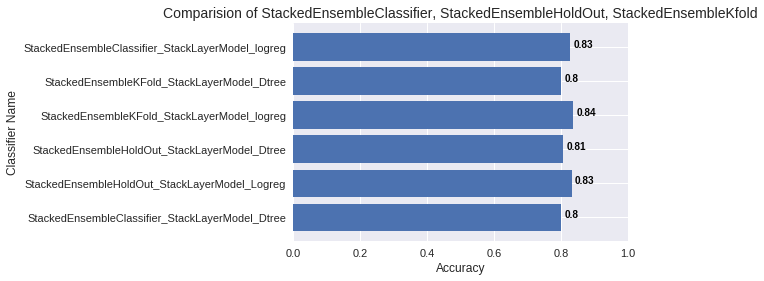

Model with highest accuracy: StackedEnsembleKFold_StackLayerModel_logreg  Accuracy: 0.84


In [82]:
print("Data Used for comparision training data X_train : ",X_train.shape,"testing data X_test",X_test.shape)
plt.xlim(0, 1.0)
_ = plt.barh(range(len(model_test_accuracy_comparisons)), list(model_test_accuracy_comparisons.values()), align='center')
_ = plt.yticks(range(len(model_test_accuracy_comparisons)), list(model_test_accuracy_comparisons.keys()))
_ = plt.title("Comparision of StackedEnsembleClassifier, StackedEnsembleHoldOut, StackedEnsembleKfold",fontsize=14)
_ = plt.xlabel('Accuracy',fontsize=12)
_ = plt.ylabel('Classifier Name',fontsize=12)
_ = plt.tick_params(axis='both', which='major', labelsize=11)
#displaying labels for each bar
for i, v in enumerate(list(model_test_accuracy_comparisons.values())):
    a=round(v,2)
    plt.text(v+0.01 , i , str(a), color='black', fontweight='bold')
plt.show()
newD = {k:round(v,2) for k, v in model_test_accuracy_comparisons.items()}
haccm = list(max(zip(newD.values(), newD.keys())))
print("Model with highest accuracy:",haccm[1]," Accuracy:",haccm[0])   

The above bar chart is showing a comparison between StackedEnsembleClassifier,StackedEnsembleHoldOut and StackedEnsembleKFold. These three classifiers were implemented and tested on MNIST fashion data. The stack layer of all three classifiers was changed once with decision tree and once with logistic regression. As can be seen in the graph, overall, logistics regression gave a better accuracy than decision tree for all classifiers. In that, StackedEnsembleKFold classifier with a stack layer model of logistic regression had the highest accuracy at 84%.

## Task 4: Comparing the Performance of Different Stack Layer Approaches with  More Standard Approaches

### Simple Decision Tree


Train the decision tree

In [38]:
my_tree = tree.DecisionTreeClassifier(criterion="entropy")
my_tree.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

Predict on test data

In [39]:
# Make a set of predictions for the test data
y_pred = my_tree.predict(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) # , normalize=True, sample_weight=None
model_test_accuracy_comparisons["Simple Tree"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))

# Print confusion matrix
# print(metrics.confusion_matrix(y_test, y_pred))

# Print nicer confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.7294444444444445
              precision    recall  f1-score   support

           0       0.73      0.67      0.70       171
           1       0.91      0.92      0.91       185
           2       0.64      0.56      0.60       194
           3       0.78      0.75      0.77       195
           4       0.49      0.57      0.53       145
           5       0.82      0.83      0.83       185
           6       0.45      0.49      0.47       171
           7       0.80      0.76      0.78       178
           8       0.83      0.84      0.83       170
           9       0.81      0.85      0.83       206

   micro avg       0.73      0.73      0.73      1800
   macro avg       0.73      0.72      0.72      1800
weighted avg       0.73      0.73      0.73      1800

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,115,2,6,13,3,1,26,0,5,0,171
1,1,170,2,8,0,0,4,0,0,0,185
2,2,1,109,5,41,1,29,0,4,2,194
3,8,10,4,147,11,0,11,0,3,1,195
4,2,1,23,8,83,0,25,0,3,0,145
5,0,1,0,3,1,154,0,13,5,8,185
6,26,1,21,1,29,0,83,1,7,2,171
7,0,0,0,0,0,19,0,135,0,24,178
8,2,0,6,3,1,7,5,0,142,4,170


### Tuned Decision tree

Grid Search 

In [40]:
# Set up the parameter grid to seaerch
param_grid ={'criterion': ['gini', "entropy"], \
             'max_depth': list(range(3, 150, 3)), \
             'min_samples_split': [10]}

# Perform the search
my_tuned_tree = GridSearchCV(tree.DecisionTreeClassifier(), \
                                param_grid, cv=cv_folds, verbose = 2, \
                            return_train_score=True)
my_tuned_tree.fit(X_train, y_train)

# Print details
print("Best parameters set found on development set:")
display(my_tuned_tree.best_params_)
model_tuned_params_list["Tuned Tree"] = my_tuned_tree.best_params_
display(my_tuned_tree.best_score_)
display(my_tuned_tree.cv_results_)

Fitting 3 folds for each of 98 candidates, totalling 294 fits
[CV] criterion=gini, max_depth=3, min_samples_split=10 ...............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  criterion=gini, max_depth=3, min_samples_split=10, total=   0.3s
[CV] criterion=gini, max_depth=3, min_samples_split=10 ...............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV]  criterion=gini, max_depth=3, min_samples_split=10, total=   0.3s
[CV] criterion=gini, max_depth=3, min_samples_split=10 ...............
[CV]  criterion=gini, max_depth=3, min_samples_split=10, total=   0.3s
[CV] criterion=gini, max_depth=6, min_samples_split=10 ...............
[CV]  criterion=gini, max_depth=6, min_samples_split=10, total=   0.6s
[CV] criterion=gini, max_depth=6, min_samples_split=10 ...............
[CV]  criterion=gini, max_depth=6, min_samples_split=10, total=   0.6s
[CV] criterion=gini, max_depth=6, min_samples_split=10 ...............
[CV]  criterion=gini, max_depth=6, min_samples_split=10, total=   0.6s
[CV] criterion=gini, max_depth=9, min_samples_split=10 ...............
[CV]  criterion=gini, max_depth=9, min_samples_split=10, total=   0.9s
[CV] criterion=gini, max_depth=9, min_samples_split=10 ...............
[CV]  criterion=gini, max_depth=9, min_samples_split=10, total=   0.9s
[CV] criterion=gini, max_depth=9, min_samples_split=10 ...............
[CV]  

[Parallel(n_jobs=1)]: Done 294 out of 294 | elapsed:  8.4min finished


Best parameters set found on development set:


{'criterion': 'entropy', 'max_depth': 9, 'min_samples_split': 10}

0.7340476190476191

{'mean_fit_time': array([0.30923573, 0.60407122, 0.93427896, 1.13709195, 1.21882693,
        1.24068753, 1.25634638, 1.2661221 , 1.22407277, 1.20112507,
        1.23795565, 1.23513095, 1.22342102, 1.2066745 , 1.20524716,
        1.19687899, 1.19126217, 1.18841108, 1.18456078, 1.18721596,
        1.18993425, 1.18814079, 1.16980378, 1.19845239, 1.1939671 ,
        1.17198396, 1.2032214 , 1.18670019, 1.18805377, 1.19750905,
        1.1815184 , 1.18789864, 1.17383575, 1.19089007, 1.18520737,
        1.16852172, 1.17363922, 1.19198783, 1.20260835, 1.19990667,
        1.2073919 , 1.18838922, 1.18399358, 1.15050475, 1.15753865,
        1.15072091, 1.15585375, 1.14657593, 1.16252136, 0.70339449,
        1.54998048, 2.1372687 , 2.27030897, 2.28354216, 2.26696952,
        2.28575754, 2.28139655, 2.2644132 , 2.26259232, 2.27694805,
        2.26469556, 2.28439633, 2.28194785, 2.27131772, 2.30049308,
        2.27184192, 2.31606587, 2.37123728, 2.37744133, 2.36067303,
        2.29793398, 2.29860655,

Test the tuned tree

In [41]:
# Make a set of predictions for the test data
y_pred = my_tuned_tree.predict(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) # , normalize=True, sample_weight=None
model_test_accuracy_comparisons["Tuned Tree"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.735
              precision    recall  f1-score   support

           0       0.72      0.68      0.70       171
           1       0.92      0.91      0.92       185
           2       0.72      0.52      0.60       194
           3       0.80      0.77      0.79       195
           4       0.49      0.60      0.54       145
           5       0.83      0.83      0.83       185
           6       0.42      0.52      0.46       171
           7       0.83      0.74      0.78       178
           8       0.84      0.84      0.84       170
           9       0.81      0.89      0.85       206

   micro avg       0.73      0.73      0.73      1800
   macro avg       0.74      0.73      0.73      1800
weighted avg       0.75      0.73      0.74      1800

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,116,3,3,7,4,0,33,0,5,0,171
1,2,169,2,8,1,0,3,0,0,0,185
2,2,1,101,4,49,0,31,0,3,3,194
3,8,6,1,151,8,1,17,0,3,0,195
4,3,0,11,10,87,0,30,0,3,1,145
5,0,1,0,3,0,153,0,16,5,7,185
6,26,2,17,1,25,1,89,0,7,3,171
7,0,0,0,0,0,20,0,132,0,26,178
8,4,0,5,3,2,4,7,0,142,3,170


### Bagging

Train the bagging model

In [42]:
my_bagmodel = ensemble.BaggingClassifier(base_estimator = tree.DecisionTreeClassifier(criterion="entropy", min_samples_leaf = 50), \
                                      n_estimators=10)
my_bagmodel.fit(X_train,y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=50, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=10, n_jobs=None, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

Test the model

In [44]:
# Make a set of predictions for the validation data
y_pred = my_bagmodel.predict(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) # , normalize=True, sample_weight=None
model_test_accuracy_comparisons["Bagging"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.7472222222222222
              precision    recall  f1-score   support

           0       0.74      0.74      0.74       171
           1       0.96      0.85      0.91       185
           2       0.77      0.55      0.64       194
           3       0.74      0.86      0.80       195
           4       0.49      0.74      0.59       145
           5       0.82      0.72      0.77       185
           6       0.53      0.42      0.46       171
           7       0.83      0.80      0.81       178
           8       0.81      0.88      0.84       170
           9       0.81      0.89      0.85       206

   micro avg       0.75      0.75      0.75      1800
   macro avg       0.75      0.74      0.74      1800
weighted avg       0.76      0.75      0.75      1800

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,126,2,1,11,1,1,20,0,9,0,171
1,0,158,3,22,0,0,1,0,1,0,185
2,0,0,106,2,66,0,15,0,5,0,194
3,5,0,0,167,5,3,12,0,3,0,195
4,0,2,7,16,108,1,11,0,0,0,145
5,1,0,0,0,0,134,1,16,8,25,185
6,38,1,15,5,30,1,71,0,10,0,171
7,0,0,0,0,0,17,0,142,0,19,178
8,0,1,3,1,9,3,4,0,149,0,170


Choose parameters using a grid search

In [45]:
# Set up the parameter grid to seaerch
param_grid = [
 {'n_estimators': list(range(10, 100, 20)),
  'base_estimator': [tree.DecisionTreeClassifier(criterion="entropy", max_depth = 6, min_samples_leaf = 10)]}
]

# Perform the search
my_tuned_model = GridSearchCV(ensemble.BaggingClassifier(), param_grid, cv=cv_folds, verbose = 2)
my_tuned_model.fit(X_train, y_train)

# Print details
print("Best parameters set found on development set:")
print(my_tuned_model.best_params_)
model_tuned_params_list["Tuned Bagging"] = my_tuned_model.best_params_
print(my_tuned_model.best_score_)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=10 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=10, total=  10.4s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=10 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.5s remaining:    0.0s


[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=10, total=  11.0s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=10 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 13.3min finished


Best parameters set found on development set:
{'base_estimator': DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), 'n_estimators': 90}
0.7830952380952381


Test on tuned bagging model

In [46]:
# Make a set of predictions for the test data
y_pred = my_tuned_model.predict(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) # , normalize=True, sample_weight=None
model_test_accuracy_comparisons["Tuned Bagging"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix")

pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.7844444444444445
              precision    recall  f1-score   support

           0       0.77      0.77      0.77       171
           1       0.99      0.88      0.93       185
           2       0.78      0.53      0.63       194
           3       0.75      0.88      0.81       195
           4       0.50      0.77      0.61       145
           5       0.91      0.85      0.88       185
           6       0.56      0.45      0.50       171
           7       0.83      0.85      0.84       178
           8       0.89      0.95      0.92       170
           9       0.88      0.90      0.89       206

   micro avg       0.78      0.78      0.78      1800
   macro avg       0.79      0.78      0.78      1800
weighted avg       0.79      0.78      0.78      1800

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,132,1,1,9,1,1,20,0,6,0,171
1,0,162,3,18,0,0,1,0,1,0,185
2,0,0,102,4,71,1,12,0,4,0,194
3,3,0,0,172,5,1,12,0,2,0,195
4,0,0,6,15,111,0,13,0,0,0,145
5,1,1,0,0,0,158,0,15,3,7,185
6,36,0,16,6,30,2,77,0,4,0,171
7,0,0,0,0,0,7,0,152,0,19,178
8,0,0,1,2,2,2,2,0,161,0,170


Plot the comparision

Data Used for comparision training data X_train :  (4200, 784) testing data X_test (1800, 784)


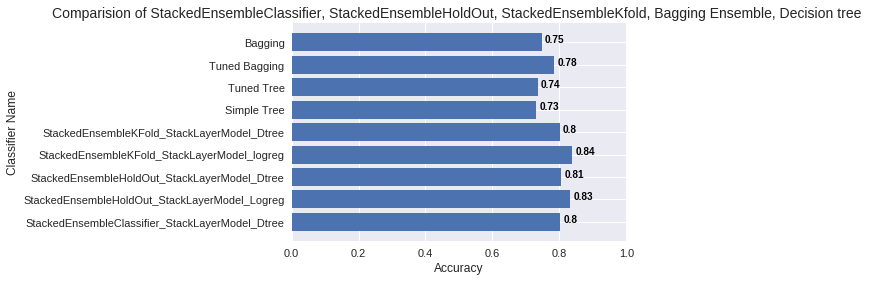

Model with highest accuracy: StackedEnsembleKFold_StackLayerModel_logreg  Accuracy: 0.84


In [76]:
print("Data Used for comparision training data X_train : ",X_train.shape,"testing data X_test",X_test.shape)
plt.xlim(0, 1.0)
_ = plt.barh(range(len(model_test_accuracy_comparisons)), list(model_test_accuracy_comparisons.values()), align='center')
_ = plt.yticks(range(len(model_test_accuracy_comparisons)), list(model_test_accuracy_comparisons.keys()))
_ = plt.title("Comparision of StackedEnsembleClassifier, StackedEnsembleHoldOut, StackedEnsembleKfold, Bagging Ensemble, Decision tree ",fontsize=14)
_ = plt.xlabel('Accuracy',fontsize=12)
_ = plt.ylabel('Classifier Name',fontsize=12)
_ = plt.tick_params(axis='both', which='major', labelsize=11)
#displaying labels for each bar
for i, v in enumerate(list(model_test_accuracy_comparisons.values())):
    a=round(v,2)
    plt.text(v+0.01 , i , str(a), color='black', fontweight='bold')
plt.show()
newD = {k:round(v,2) for k, v in model_test_accuracy_comparisons.items()}
haccm = list(max(zip(newD.values(), newD.keys())))
print("Model with highest accuracy:",haccm[1]," Accuracy:",haccm[0])   

The above graph shows a comparison of StackedEnsembleClassifier, StackedEnsembleHoldOut, StackedEnsembleKFold, BaggingEnsemble and Decision Tree. The three StackedEnsembles were run after modifying the stack layer with decision tree and logistic regression. For bagging and decision tree classifier, grid search was used to tune parameters and run to get outputs for tuned bagging and tuned tree. As is seen in the graph, the highest accuracy was still given by StackedEnsembleKFold with a stack layer model of logistic regression at 84%. The accuracy of bagging and decision tree was low compared to the StackedEnsembles.

## Task 5: Implement the StackedEnsembleOneVsOne Class

In [0]:
# Write your code here
# Create a new classifier which is based on the sckit-learn BaseEstimator and ClassifierMixin classes
class StackedEnsembleOneVsOne(BaseEstimator, ClassifierMixin):
    
    """An ensemble classifier that uses heterogeneous models at the base layer and a aggregatnio model at the aggregation layer. A k-fold cross validation is used to gnerate training data for the stack layer model.

    Parameters
    ----------
    base_estimators: list 
        A list of the classifiers in the base layer of the ensemble. Supported types are
        - "svm" Support Vector Machine implemented by sklearn.svm.SVC
        - "logreg" Logistic Regression implemented by sklearn.linear_models.LogisticRegression
        - "knn" k Nearest Neighbour implemented by sklearn.neighbors.KNeighborsClassifier
        - "tree" Decision Tree implemented by sklearn.tree.DecisionTreeClassifier
        - "randomforest" RandomForest implemented by sklearn.tree.RandomForestClassifier    
    classifier_duplicates: int, optional (default = 1)
        How many instances of each classifier type listed in base_estimators is included in the ensemble
    stack_layer_classifier: string, optional (default = "logreg')
        The classifier type used at the stack layer. The same classifier types as are supported at the base layer are supported        
    training_folds: int, optional (default = 4)
        How many folds will be used to generate the training set for the stacked layer
        
    Attributes
    ----------
    classes_ : array of shape = [n_classes] 
        The classes labels (single output problem).


    Notes
    -----
    The default values for most base learners are used.

    See also
    --------
    
    ----------
    .. [1]  van der Laan, M., Polley, E. & Hubbard, A. (2007). 
            Super Learner. Statistical Applications in Genetics 
            and Molecular Biology, 6(1) 
            doi:10.2202/1544-6115.1309
    Examples
    --------
    >>> from sklearn.datasets import load_iris
    >>> from sklearn.model_selection import cross_val_score
    >>> clf = StackedEnsembleClassifier()
    >>> iris = load_iris()
    >>> cross_val_score(clf, iris.data, iris.target, cv=10)

    """
    # Constructor for the classifier object
    def __init__(self, base_estimator_types = "svm", base_estimator_duplicates = 8, stack_layer_classifier_type = "logreg"):
        """Setup a SuperLearner classifier .
        Parameters
        ----------
        base_estimator_types: The types of classifiers to include at the base layer
        base_estimator_duplicates: The number of duplicates of each type of classiifer to include
        stack_layer_classifier_type: The type of classifier to include at the stack layer 
        
        Returns
        -------
        Nothing
        """     

        # Initialise class variabels
        self.base_estimator_types = base_estimator_types
        self.base_estimator_type_list = list()
        self.base_estimator_duplicates = base_estimator_duplicates
        self.stack_layer_classifier_type = stack_layer_classifier_type

    # The fit function to train a classifier
    def fit(self, X, y):
        """Build a SuperLearner classifier from the training set (X, y).
        Parameters
        ----------
        X : array-like, shape = [n_samples, n_features]
            The training input samples. 
        y : array-like, shape = [n_samples] 
            The target values (class labels) as integers or strings.
        Returns
        -------
        self : object
        """    
        
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        # Store the classes seen during fit
        self.classes_ = unique_labels(y)
        
        #store all the pairs of the classes. Calculated the combination of unique classes
        pairs = list(itertools.combinations(self.classes_, 2)) 
        
        ########################
        # LEVEL 0
        ########################
        
        # Set up the base classifeirs in the ensemble
        self.classifiers_ = list()
        
        # Set up empty arrays to hold stack layer training data
        self.X_stack_train = None #(dtype = float)
        self.y_stack_train = y
        
        
        clf=self.base_estimator_types
        
        #for each pair a classifier is created and is trained on data having class in the pair.
        #and then the classifier is made a make a prediction on entire data set, its ypred is used as training for stack layes
        for pair in pairs:
            
            #create classifier
            c = create_classifier(clf, tree_min_samples_split=math.ceil(len(X)*0.05))
            
            X_train=None
            y_train=None
            index=None
            
            #get index of class for the given pair
            index = np.array(np.where(np.isin(y,pair)))
              
            #from the indexex get the data X and y    
            for ind, x in enumerate(X):
                x=np.reshape(x,(1,-1))
                if ind in index:
                    try:
                        X_train=np.concatenate((X_train,x),axis=0)                    
                    except ValueError:
                        X_train=x
            
            for ind, yi in enumerate(y):
                yi=np.reshape(yi,(1,-1))
                if ind in index:
                    try:
                        y_train=np.concatenate((y_train,yi),axis=0)                    
                    except ValueError:
                        y_train=yi
            
            #Rsample the data
            #X_train_samp, y_train_samp = resample(X_train, y_train, replace=True)    
            
            # Train a base classifier np.ravel is used to supress warning thrown by svm
            c.fit(X_train, np.ravel(y_train,order='C'))
            
            #store the classifiers
            self.classifiers_.append(c)
            
            # Make predictions for all instances in the training set
            y_pred = c.predict_proba(X)

            # Append the predictions ot the stack layer traing set (a bit of hacking here!)
            try:
                self.X_stack_train = np.c_[self.X_stack_train, y_pred]
            except ValueError:
                self.X_stack_train = y_pred
            
                                  
            
        # Store the number of classifers in the ensemble
        self.n_estimators_ = len(self.classifiers_)
              
     
        ########################
        # LEVEL 1
        ########################
        
        # Create the stack layer classifier
        self.stack_layer_classifier_ = create_classifier(self.stack_layer_classifier_type, tree_min_samples_split=math.ceil(len(X)*0.05))

        # Train the stack layer using the newly created dataset
        self.stack_layer_classifier_.fit(self.X_stack_train, self.y_stack_train)

        # Return the classifier
        return self

    # The predict function to make a set of predictions for a set of query instances
    def predict(self, X):
        """Predict class labels of the input samples X.
        Parameters
        ----------
        X : array-like matrix of shape = [n_samples, n_features]
            The input samples. 
        Returns
        -------
        p : array of shape = [n_samples, ].
            The predicted class labels of the input samples. 
        """
        
        # Check is fit had been called by confirming that the teamplates_ dictiponary has been set up
        check_is_fitted(self, ['stack_layer_classifier_'])
        

        # Check that the input features match the type and shape of the training features
        X = check_array(X)
        
   
        X_stack_queries = None
              
        # Make a prediction with each base classifier and assemble the stack layer query
        for classifier in self.classifiers_:
            
            y_pred = classifier.predict_proba(X)
            
            try:
                X_stack_queries = np.c_[X_stack_queries, y_pred]
            except ValueError:
                X_stack_queries = y_pred
        
        # Return the prediction made by the stack layer classifier
        return self.stack_layer_classifier_.predict(X_stack_queries)
    
    # The predict function to make a set of predictions for a set of query instances
    def predict_proba(self, X):
        """Predict class probabilities of the input samples X.
        Parameters
        ----------
        X : array-like matrix of shape = [n_samples, n_features]
            The input samples. 
        Returns
        -------
        p : array of shape = [n_samples, n_labels].
            The predicted class label probabilities of the input samples. 
        """
        # Check is fit had been called by confirming that the teamplates_ dictiponary has been set up
        check_is_fitted(self, ['stack_layer_classifier_'])

        # Check that the input features match the type and shape of the training features
        X = check_array(X)
        
        X_stack_queries = None
        
        # Make a prediction with each base classifier
        for classifier in self.classifiers_:
            
            y_pred = classifier.predict_proba(X)
                
            try:
                X_stack_queries = np.c_[X_stack_queries, y_pred]
            except ValueError:
                X_stack_queries = y_pred

        # Return the prediction made by the stack layer classifier        
        return self.stack_layer_classifier_.predict_proba(X_stack_queries)


## Test the StackedEnsembleOneVsOne

Perform a simple test using the StackedEnsembleOneVsOne on the Iris dataset

In [49]:
from sklearn.datasets import load_iris
iris = load_iris()
clf = StackedEnsembleOneVsOne()
clf.fit(iris.data, iris.target)
y_pred = clf.predict(iris.data)
print(metrics.classification_report(iris.target, y_pred))
print("Confusion Matrix")
display(pd.crosstab(np.array(iris.target), y_pred, rownames=['True'], colnames=['Predicted'], margins=True))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      0.96      0.98        50
           2       0.96      1.00      0.98        50

   micro avg       0.99      0.99      0.99       150
   macro avg       0.99      0.99      0.99       150
weighted avg       0.99      0.99      0.99       150

Confusion Matrix


Predicted,0,1,2,All
True,,,,
0,50,0,0,50
1,0,48,2,50
2,0,0,50,50
All,50,48,52,150


Perform a cross validation experiment

In [50]:
scores = cross_val_score(clf, iris.data, iris.target, cv=10)
print(scores)
print(np.mean(scores), " +/- ", np.std(scores))

[1.         0.93333333 1.         1.         0.93333333 0.93333333
 0.93333333 1.         1.         1.        ]
0.9733333333333334  +/-  0.03265986323710904


## Task 6 Evaluate the Performance of the StackedEnsembleCalassifierOneVsOne Algorithm

### StackedEnsembleOneVsOne


Train StackedEnsembleOneVsOne model with stack layer model logestic regression

In [51]:
StackedEnsembleOneVsOne_logregmodel = StackedEnsembleOneVsOne()
StackedEnsembleOneVsOne_logregmodel.fit(X_train, y_train)

StackedEnsembleOneVsOne(base_estimator_duplicates=8,
            base_estimator_types='svm',
            stack_layer_classifier_type='logreg')

Make prediction on test data

In [52]:
# Make a set of predictions for the training data
y_pred = StackedEnsembleOneVsOne_logregmodel.predict(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) # , normalize=True, sample_weight=None
model_test_accuracy_comparisons["StackedEnsembleOneVsOne_StackLayerModel_logreg"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))

# Print confusion matrix
# print(metrics.confusion_matrix(y_train, y_pred))

# Print nicer homemade confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.8216666666666667
              precision    recall  f1-score   support

           0       0.75      0.78      0.76       171
           1       0.98      0.96      0.97       185
           2       0.76      0.71      0.73       194
           3       0.86      0.87      0.86       195
           4       0.62      0.75      0.68       145
           5       0.89      0.90      0.89       185
           6       0.61      0.46      0.52       171
           7       0.87      0.84      0.85       178
           8       0.89      0.97      0.93       170
           9       0.90      0.94      0.92       206

   micro avg       0.82      0.82      0.82      1800
   macro avg       0.81      0.82      0.81      1800
weighted avg       0.82      0.82      0.82      1800

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,133,1,3,11,0,3,13,0,6,1,171
1,1,178,1,3,0,0,2,0,0,0,185
2,0,1,138,2,37,0,13,0,3,0,194
3,7,0,1,169,8,1,7,0,2,0,195
4,0,0,16,6,109,0,13,0,1,0,145
5,0,0,0,0,0,166,0,13,3,3,185
6,37,0,23,5,22,0,79,0,5,0,171
7,0,0,0,0,0,12,0,149,0,17,178
8,0,1,0,0,0,1,3,0,165,0,170


Train StackedEnsembleOneVsOne model with stack layer model Decision Tree

In [53]:
StackedEnsembleOneVsOne_treemodel = StackedEnsembleOneVsOne(stack_layer_classifier_type='tree')
StackedEnsembleOneVsOne_treemodel.fit(X_train, y_train)

StackedEnsembleOneVsOne(base_estimator_duplicates=8,
            base_estimator_types='svm', stack_layer_classifier_type='tree')

Make prediction on test data

In [54]:
# Make a set of predictions for the training data
y_pred = StackedEnsembleOneVsOne_treemodel.predict(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) # , normalize=True, sample_weight=None
model_test_accuracy_comparisons["StackedEnsembleOneVsOne_StackLayerModel_Dtree"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))

# Print confusion matrix
# print(metrics.confusion_matrix(y_train, y_pred))

# Print nicer homemade confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.7555555555555555
              precision    recall  f1-score   support

           0       0.69      0.77      0.72       171
           1       0.99      0.92      0.96       185
           2       0.81      0.49      0.62       194
           3       0.83      0.75      0.79       195
           4       0.47      0.75      0.58       145
           5       0.82      0.89      0.85       185
           6       0.43      0.46      0.44       171
           7       0.83      0.75      0.79       178
           8       0.91      0.93      0.92       170
           9       0.87      0.84      0.86       206

   micro avg       0.76      0.76      0.76      1800
   macro avg       0.77      0.75      0.75      1800
weighted avg       0.78      0.76      0.76      1800

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,131,0,0,15,1,1,21,0,2,0,171
1,2,171,0,4,3,0,5,0,0,0,185
2,1,0,96,1,77,0,19,0,0,0,194
3,11,0,1,146,10,0,25,0,2,0,195
4,0,0,5,8,109,0,23,0,0,0,145
5,1,0,0,0,0,164,0,8,6,6,185
6,45,0,16,1,27,0,78,0,4,0,171
7,0,0,0,0,0,27,0,133,0,18,178
8,0,1,0,0,1,4,4,1,158,1,170


plot the comparision

Data Used for comparision training data X_train :  (4200, 784) testing data X_test (1800, 784)


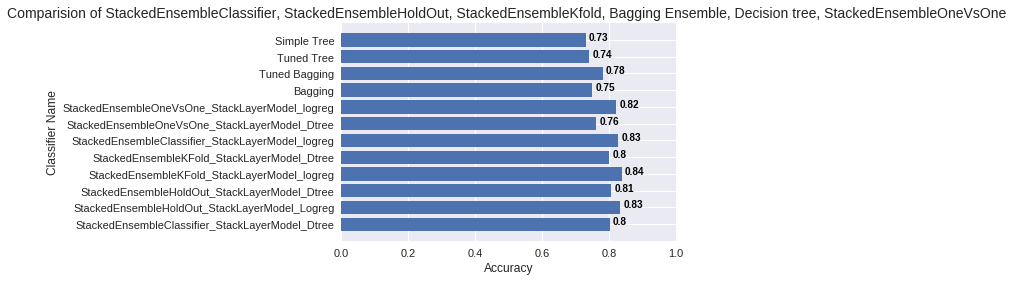

Model with highest accuracy: StackedEnsembleKFold_StackLayerModel_logreg  Accuracy: 0.84


In [84]:
print("Data Used for comparision training data X_train : ",X_train.shape,"testing data X_test",X_test.shape)

plt.xlim(0, 1.0)
_ = plt.barh(range(len(model_test_accuracy_comparisons)), list(model_test_accuracy_comparisons.values()), align='center')
_ = plt.yticks(range(len(model_test_accuracy_comparisons)), list(model_test_accuracy_comparisons.keys()))
_ = plt.title("Comparision of StackedEnsembleClassifier, StackedEnsembleHoldOut, StackedEnsembleKfold, Bagging Ensemble, Decision tree, StackedEnsembleOneVsOne ",fontsize=14)
_ = plt.xlabel('Accuracy',fontsize=12)
_ = plt.ylabel('Classifier Name',fontsize=12)
_ = plt.tick_params(axis='both', which='major', labelsize=11)
#displaying labels for each bar
for i, v in enumerate(list(model_test_accuracy_comparisons.values())):
    a=round(v,2)
    plt.text(v+0.01 , i , str(a), color='black', fontweight='bold')
plt.show()
newD = {k:round(v,2) for k, v in model_test_accuracy_comparisons.items()}
haccm = list(max(zip(newD.values(), newD.keys())))
print("Model with highest accuracy:",haccm[1]," Accuracy:",haccm[0])   

StackedEnsembleOneVsOne was added to the comparison of classifiers. This classifier was also modelled once for decision tree and once for logistic regression. The highest accuracy is again found with StackedEnsembleKFold with logistic regression model at 84%

## Task 7 Reflect on the Performance of the Different Models Evaluated

*Write your reflection here (max 300 words)*

From all the classifiers above StackEnsembleKFold classifier performed well with an accuracy of 84% in my case on MINIST Data. There is only 1% difference in the accuracy of StackEnsembleHoldOut, StackEnsembleClassifier and StackEnsembleKFold which is not much. StackEnsembleKFold performed well because Kfold was performed on each of the base classifier to generate data for stack layer, and at the end base classifiers were again trained on full data set. The performance of  StackEnsembleOneVsOne was comparatively good with an accuracy of 82% using logistic regression for stack model. It was be observed that using Decision tree as stack model gave a low accuracy compared to using logistic regression for stack model. Simple bagging and boosting were poor in performing on this dataset.